In [1]:
import pandas as pd
from networkx.classes import edges

# Load centrality data
centrality_df = pd.read_excel("data/Centrality_indices.xlsx")
print("Columns:", centrality_df.columns)
print("Sample rows:\n", centrality_df.head())

# See how many unique municipalities there are
unique_cities = centrality_df['Codmundv'].nunique()
print(f"Number of unique municipalities in centrality data: {unique_cities}")


Columns: Index(['Codmundv', 'UF', 'Cod_UF', 'nomemun', 'VAR01', 'VAR02', 'VAR03',
       'VAR04', 'VAR05'],
      dtype='object')
Sample rows:
    Codmundv        UF  Cod_UF                nomemun     VAR01     VAR02  \
0   1100015  Rondônia      11  ALTA FLORESTA D'OESTE  0.304170  0.000000   
1   1100023  Rondônia      11              ARIQUEMES  0.417148  0.007206   
2   1100031  Rondônia      11                 CABIXI  0.234459  0.000000   
3   1100049  Rondônia      11                 CACOAL  0.405658  0.001383   
4   1100056  Rondônia      11             CEREJEIRAS  0.306267  0.000738   

       VAR03     VAR04  VAR05  
0  30.416971  0.000000      9  
1  41.714770  0.720614    125  
2  23.445949  0.000000      1  
3  40.565826  0.138341    104  
4  30.626660  0.073794     12  
Number of unique municipalities in centrality data: 5386


In [2]:
import importlib
import codes.extract_backbone

importlib.reload(codes.extract_backbone)
from codes.extract_backbone import extract_backbone_from_files_brazil

backbone_df = extract_backbone_from_files_brazil(
    centrality_path="data/Centrality_indices.xlsx",
    mobility_edges_path="data/Road_and_waterway_connections_database_2016.xlsx",
    alpha=0.01
)

print(f"Backbone extracted with {len(backbone_df)} edges")
print(backbone_df[['source', 'target', 'weekly_flow', 'pij']].head())


[✓] Backbone file found at 'data/mobility_backbone_brazil.csv'. Loading it...
Backbone extracted with 20057 edges
    source   target  weekly_flow       pij
0  1302603  1304260          7.5  0.624295
1  1302108  1302603          3.0  0.678201
2  5103809  5108402          0.0  1.000000
3  1300029  1302603          7.5  0.732111
4  1300029  1301308          6.0  0.728335


In [3]:
import pandas as pd

# Load the population dataset (skip first two header rows)
pop_df = pd.read_excel(
    "data/CD2022_Collected_Imputed_Population_and_Total_Municipality_and_State_20231222.xlsx",
    skiprows=2
)

# Rename columns for clarity
pop_df = pop_df.rename(columns={
    'COD. UF': 'state_code',
    'COD. MUNIC': 'municipality_code_suffix',
    'NOME DO MUNICÍPIO': 'municipality_name',
    'POP. COLETADA': 'population_collected',
    'POP. IMPUTADA': 'population_imputed',
    'POP. TOTAL': 'population_total'
})

# Drop any rows with missing key info
pop_df = pop_df.dropna(subset=['state_code', 'municipality_code_suffix', 'population_total'])

# Create full 7-digit IBGE municipality code (as integer)
pop_df['Codmundv'] = (
    pop_df['state_code'].astype(int).astype(str).str.zfill(2) +
    pop_df['municipality_code_suffix'].astype(int).astype(str).str.zfill(5)
).astype(int)

# Confirm it's clean
print(pop_df[['Codmundv', 'municipality_name', 'population_total']].head())
print(f"\nTotal valid municipalities with population data: {pop_df['Codmundv'].nunique()}")
    

   Codmundv      municipality_name  population_total
0   1100015  Alta Floresta D'Oeste           21494.0
1   1100023              Ariquemes           96833.0
2   1100031                 Cabixi            5351.0
3   1100049                 Cacoal           86887.0
4   1100056             Cerejeiras           15890.0

Total valid municipalities with population data: 5570


In [4]:
from codes.load_and_save_covid_data import load_and_save_covid_data

covid_df = load_and_save_covid_data()

print(f"Full date range: {covid_df['date'].min()} to {covid_df['date'].max()}")
print(f"Total records: {len(covid_df):,}")


[✓] Found saved COVID dataset at data/covid_brazil_combined.csv. Loading it...
Full date range: 2020-02-25 00:00:00 to 2023-03-18 00:00:00
Total records: 5,830,987


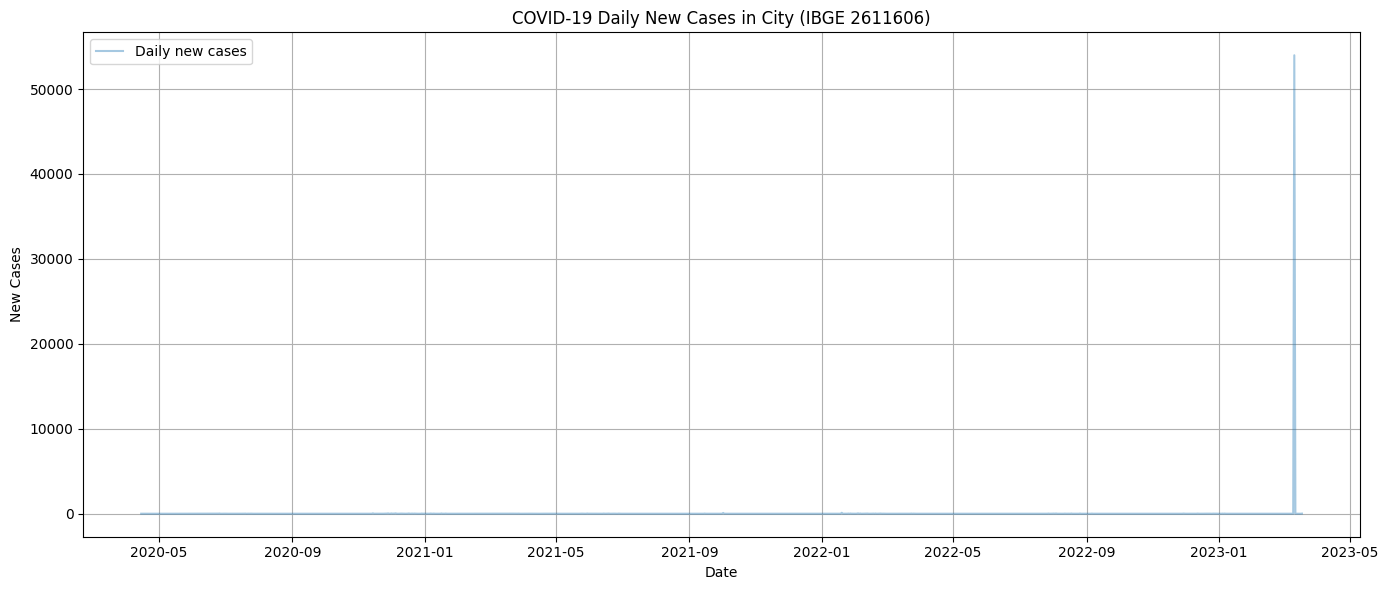

In [26]:
import matplotlib.pyplot as plt

# Filter data for São Paulo
city = covid_df[covid_df['ibgeID'] == 3300936]

# Plotting new cases over time
plt.figure(figsize=(14, 6))
plt.plot(city['date'], city['newCases'], label='Daily new cases', alpha=0.4)
# plt.plot(city['date'], city['newCases'].rolling(window=7).mean(), label='7-day rolling avg', color='red')

# Labels and legend
plt.title("COVID-19 Daily New Cases in City (IBGE 2611606)")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
import pandas as pd

# Load COVID dataset
covid_df = load_and_save_covid_data()  # Assuming this function loads your dataset
covid_df['date'] = pd.to_datetime(covid_df['date'])

# Load population data
pop_df = pd.read_excel(
    "data/CD2022_Collected_Imputed_Population_and_Total_Municipality_and_State_20231222.xlsx",
    skiprows=2
)

# Drop rows with missing municipality info
pop_df = pop_df.dropna(subset=['COD. UF', 'COD. MUNIC'])

# Rename and prepare codes
pop_df = pop_df.rename(columns={
    'COD. UF': 'state_code',
    'COD. MUNIC': 'municipality_code_suffix',
    'NOME DO MUNICÍPIO': 'municipality_name',
})

pop_df['state_code'] = pop_df['state_code'].astype(int)
pop_df['municipality_code_suffix'] = pop_df['municipality_code_suffix'].astype(int)

pop_df['Codmundv'] = (
    pop_df['state_code'].astype(str).str.zfill(2) +
    pop_df['municipality_code_suffix'].astype(str).str.zfill(5)
).astype(int)

# ========== 1. Flag cities with 60-day zero-case streak ==========
flagged_zero_cities = []

for ibge_id, group in covid_df.groupby('ibgeID'):
    group_sorted = group.sort_values('date')
    zero_cases = group_sorted['newCases'].fillna(0) == 0
    rolling_zero = zero_cases.rolling(window=60).sum()
    if (rolling_zero == 60).any():
        flagged_zero_cities.append(ibge_id)

# ========== 2. Flag cities with negative values ==========
flagged_negative_cities = []
count_negative = 0

for ibge_id, group in covid_df.groupby('ibgeID'):
    if (group['newCases'].fillna(0) < -1000).any():
        count_negative += 1
        flagged_negative_cities.append(ibge_id)
print(f"Count of Negative Cities: {count_negative}")

# ========== 3. Combine both flagged groups ==========
combined_flagged_cities = set(flagged_zero_cities) | set(flagged_negative_cities)

combined_flagged_df = pd.DataFrame(combined_flagged_cities, columns=['Codmundv'])
combined_flagged_df = combined_flagged_df.merge(
    pop_df[['Codmundv', 'municipality_name']],
    on='Codmundv',
    how='left'
)

print(f"\n✅ Total cities flagged (zero-case or negative cases): {len(combined_flagged_df)}")
print(combined_flagged_df.sample(5, random_state=1))


# ========== 4. See non-flagged cities ==========
all_cities = covid_df['ibgeID'].unique()
non_flagged_cities = [city for city in all_cities if city not in combined_flagged_cities]

non_flagged_df = pd.DataFrame(non_flagged_cities, columns=['Codmundv'])
non_flagged_df = non_flagged_df.merge(
    pop_df[['Codmundv', 'municipality_name']],
    on='Codmundv',
    how='left'
)

print(f"\n✅ Number of non-flagged cities: {len(non_flagged_df)}")
print(non_flagged_df.sample(5, random_state=42))


# ========== 5. (Optional) See only negative-flagged cities ==========
only_negative_df = pd.DataFrame(
    [c for c in flagged_negative_cities if c not in flagged_zero_cities],
    columns=['Codmundv']
).merge(
    pop_df[['Codmundv', 'municipality_name']],
    on='Codmundv',
    how='left'
)

print(f"\n⚠️ Cities flagged ONLY for negative values: {len(only_negative_df)}")
print(only_negative_df.sample(5, random_state=99))



[✓] Found saved COVID dataset at data/covid_brazil_combined.csv. Loading it...
Count of Negative Cities: 326

✅ Total cities flagged (zero-case or negative cases): 3242
      Codmundv      municipality_name
3011   2907608                Central
473    1500347     Água Azul do Norte
1796   4305439                   Chuí
318    2310951         Pires Ferreira
2151   4306353  Dezesseis de Novembro

✅ Number of non-flagged cities: 2355
      Codmundv      municipality_name
1905   4312658           Não-Me-Toque
670    3124104             Esmeraldas
694    3133758          Itaú de Minas
2067   5003488  Dois Irmãos do Buriti
1178   3540705         Porto Ferreira

⚠️ Cities flagged ONLY for negative values: 209
     Codmundv   municipality_name
72    2602001              Bodocó
24    2313104  Tabuleiro do Norte
51    2409506        Pedra Grande
170   2906006       Campo Formoso
98    2606804            Igarassu


In [27]:
3300936 in combined_flagged_cities

False

In [17]:
unique_cities = covid_df['ibgeID'].nunique()
print(f"Total unique municipalities in COVID dataset: {unique_cities}")

# Step 1: Get list of valid municipality codes from centrality
valid_city_ids = centrality_df['Codmundv'].dropna().astype(int).unique()

# Step 2: Filter COVID time series to those cities
filtered_covid_df = covid_df[covid_df['ibgeID'].isin(valid_city_ids)].copy()

# Step 3: Sanity check
print(f"Filtered COVID data has {filtered_covid_df['ibgeID'].nunique()} cities")
print(f"Total rows: {len(filtered_covid_df):,}")


Total unique municipalities in COVID dataset: 5597
Filtered COVID data has 5386 cities
Total rows: 5,612,112


In [53]:
city_counts = filtered_covid_df['ibgeID'].value_counts()
print(city_counts.head(10))

top_cities = filtered_covid_df.groupby('ibgeID')['city'].first().loc[city_counts.head(10).index]
print(top_cities)


ibgeID
3550308    1118
3300407    1109
3304557    1108
2910800    1108
5300108    1107
3547304    1107
2704302    1106
3122306    1106
4303905    1104
4314902    1103
Name: count, dtype: int64
ibgeID
3550308              São Paulo/SP
3300407            Barra Mansa/RJ
3304557         Rio de Janeiro/RJ
2910800       Feira de Santana/BA
5300108               Brasília/DF
3547304    Santana de Parnaíba/SP
2704302                 Maceió/AL
3122306            Divinópolis/MG
4303905              Campo Bom/RS
4314902           Porto Alegre/RS
Name: city, dtype: object


In [54]:
def zscore_safe(x):
    std = x.std(ddof=0)
    if std == 0 or pd.isna(std):
        return pd.Series([0]*len(x), index=x.index)  # All zeros if no variation
    return (x - x.mean()) / std

# Apply to both newCases and newDeaths
filtered_covid_df['z_newCases'] = filtered_covid_df.groupby('ibgeID')['newCases'].transform(zscore_safe)
filtered_covid_df['z_newDeaths'] = filtered_covid_df.groupby('ibgeID')['newDeaths'].transform(zscore_safe)


In [55]:
# Check that it worked
print(filtered_covid_df.groupby('ibgeID')['z_newCases'].mean().round(2).describe())
print(filtered_covid_df.groupby('ibgeID')['z_newCases'].std().round(2).describe())


count    5386.0
mean        0.0
std         0.0
min        -0.0
25%         0.0
50%         0.0
75%        -0.0
max         0.0
Name: z_newCases, dtype: float64
count    5386.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: z_newCases, dtype: float64


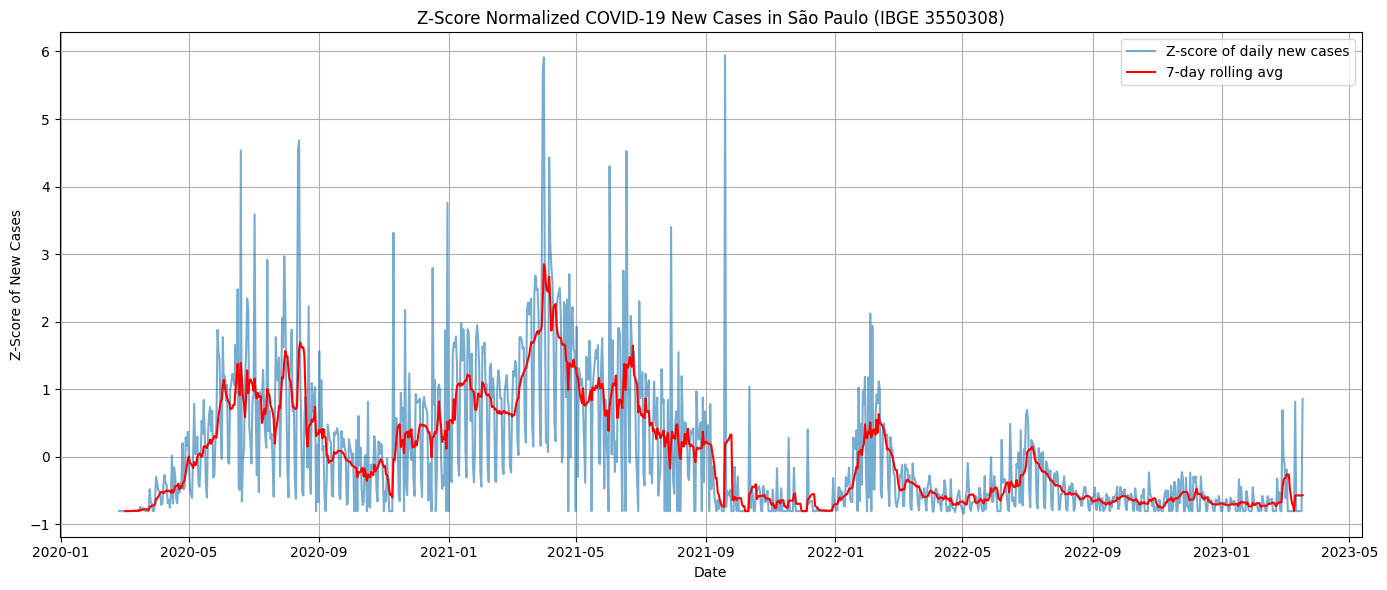

In [56]:
import matplotlib.pyplot as plt

# Filter for São Paulo by IBGE code (3550308)
sp_df = filtered_covid_df[filtered_covid_df['ibgeID'] == 3550308]

# Plot z-normalized new cases
plt.figure(figsize=(14, 6))
plt.plot(sp_df['date'], sp_df['z_newCases'], label='Z-score of daily new cases', alpha=0.6)
plt.plot(sp_df['date'], sp_df['z_newCases'].rolling(window=7).mean(), color='red', label='7-day rolling avg')

plt.title("Z-Score Normalized COVID-19 New Cases in São Paulo (IBGE 3550308)")
plt.xlabel("Date")
plt.ylabel("Z-Score of New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
import networkx as nx

# 1. Create an undirected weighted graph
G = nx.Graph()

# 2. Add nodes from centrality dataset
for _, row in centrality_df.iterrows():
    city_id = int(row['Codmundv'])
    G.add_node(city_id, name=row['nomemun'])

# 3. Add filtered + backbone edges
for _, row in backbone_df.iterrows():
    source = int(row['source'])
    target = int(row['target'])
    weight = row['weekly_flow']

    # Avoid adding duplicate edges or self-loops
    if source != target and not G.has_edge(source, target):
        G.add_edge(source, target, weight=weight)

print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


Graph built with 5386 nodes and 20057 edges.


In [142]:
import torch
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data

# Step 1: Add edge weight as 'edge_weight'
for u, v, d in G.edges(data=True):
    d['edge_weight'] = d['weight']

# Step 2: Convert to PyG format (skip node attributes like 'name')
pyg_data = from_networkx(G, group_edge_attrs=['edge_weight'])

print(pyg_data)


Data(edge_index=[2, 40114], name=[5386], weight=[40114], edge_attr=[40114, 1], num_nodes=5386)


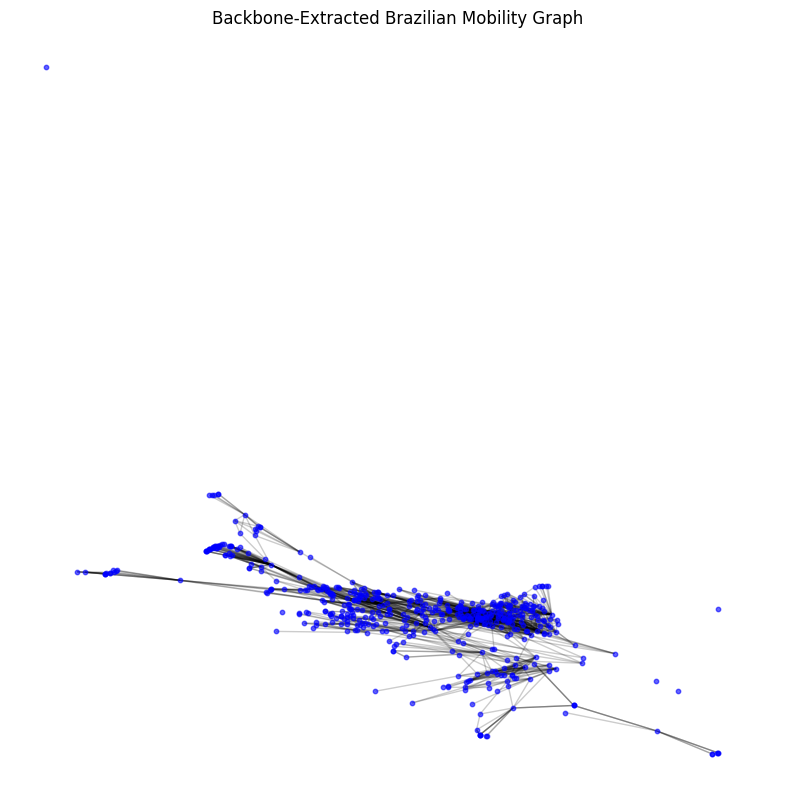

In [66]:
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Convert back to NetworkX for plotting
G_nx = to_networkx(pyg_data, to_undirected=True)

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_nx, seed=42)

# Subsample for clarity if needed
sample_nodes = list(G_nx.nodes)[:500]
nx.draw_networkx_nodes(G_nx, pos, nodelist=sample_nodes, node_size=10, node_color='blue', alpha=0.6)
nx.draw_networkx_edges(G_nx, pos, edgelist=[e for e in G_nx.edges if e[0] in sample_nodes and e[1] in sample_nodes], alpha=0.2)

plt.title("Backbone-Extracted Brazilian Mobility Graph")
plt.axis("off")
plt.show()


In [143]:
# Ensure it's sorted by city and date
filtered_covid_df = filtered_covid_df.sort_values(by=['ibgeID', 'date'])

# Get unique sorted dates
unique_dates = filtered_covid_df['date'].sort_values().unique()
n_dates = len(unique_dates)

# Find split index
split_idx = int(n_dates * 0.8)
split_date = unique_dates[split_idx]

# Split the data
train_df = filtered_covid_df[filtered_covid_df['date'] <= split_date]
test_df = filtered_covid_df[filtered_covid_df['date'] > split_date]

print(f"Training dates: {train_df['date'].min()} → {train_df['date'].max()} ({train_df.shape[0]:,} records)")
print(f"Testing dates:  {test_df['date'].min()} → {test_df['date'].max()} ({test_df.shape[0]:,} records)")


Training dates: 2020-02-25 00:00:00 → 2022-08-07 00:00:00 (4,411,034 records)
Testing dates:  2022-08-08 00:00:00 → 2023-03-18 00:00:00 (1,201,078 records)


In [153]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

if torch.backends.mps.is_available():
    device = torch.device("cpu")
    print('Using cpu')
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class GConvGRUCell(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GConvGRUCell, self).__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.conv_z = GCNConv(in_channels + hidden_channels, hidden_channels)
        self.conv_r = GCNConv(in_channels + hidden_channels, hidden_channels)
        self.conv_h = GCNConv(in_channels + hidden_channels, hidden_channels)

    def forward(self, x, h, edge_index, edge_weight=None):
        xh = torch.cat([x, h], dim=-1)
        z = torch.sigmoid(self.conv_z(xh, edge_index, edge_weight))
        r = torch.sigmoid(self.conv_r(xh, edge_index, edge_weight))
        rh = torch.cat([x, r * h], dim=-1)
        h_tilde = torch.tanh(self.conv_h(rh, edge_index, edge_weight))
        h_next = (1 - z) * h + z * h_tilde
        return h_next


Using cpu


In [154]:
class GCRN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCRN, self).__init__()
        self.gconv_gru = GConvGRUCell(in_channels, hidden_channels)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_channels, out_channels)

    def forward(self, x_seq, edge_index, edge_weight=None):
        # x_seq: [T, N, F] – sequence of inputs
        T, N, F = x_seq.size()
        h = torch.zeros(N, self.gconv_gru.hidden_channels).to(x_seq.device)

        for t in range(T):
            h = self.gconv_gru(x_seq[t], h, edge_index, edge_weight)

        out = self.linear(self.relu(h))
        return out


In [155]:
import torch

# Use GPU if available, otherwise fall back to CPU
print("Using device:", device)

# Input: (sequence_length=15, num_nodes=5386, features=1)
input_seq = torch.rand(15, 5386, 1).to(device)
edge_index = pyg_data.edge_index.to(device)
edge_weight = pyg_data.edge_attr.view(-1).to(device)

model = GCRN(in_channels=1, hidden_channels=64, out_channels=1).to(device)
output = model(input_seq, edge_index, edge_weight)

print(output.shape)  # Expected: [5386, 1]


Using device: cpu
torch.Size([5386, 1])


In [156]:
import numpy as np
import torch

# Step 1: Assume filtered_covid_df is already sorted by ['ibgeID', 'date']
# and only includes the 5386 cities from centrality
# Ensure we have columns: ['date', 'ibgeID', 'z_newCases']

# Pivot to shape [num_days, num_cities]
pivot_df = filtered_covid_df.pivot(index='date', columns='ibgeID', values='z_newCases').sort_index()

# Step 2: Convert to numpy array and fill NaNs with 0
data_array = pivot_df.fillna(0).to_numpy()  # shape: [num_days, num_nodes]

num_days, num_nodes = data_array.shape

# Step 3: Create segments
sequence_length = 15
X_list = []
Y_list = []

for i in range(num_days - sequence_length):
    x_seq = data_array[i:i+sequence_length]       # shape: [15, num_nodes]
    y_target = data_array[i+sequence_length]      # shape: [num_nodes]

    # Reshape for model compatibility
    x_seq = np.expand_dims(x_seq, axis=-1)        # [15, num_nodes, 1]
    y_target = np.expand_dims(y_target, axis=-1)  # [num_nodes, 1]

    X_list.append(x_seq)
    Y_list.append(y_target)

# Step 4: Convert to torch tensors
X = torch.tensor(np.array(X_list), dtype=torch.float32).to(device)  # [num_samples, 15, num_nodes, 1]
Y = torch.tensor(np.array(Y_list), dtype=torch.float32).to(device)  # [num_samples, num_nodes, 1]

print("X shape:", X.shape)
print("Y shape:", Y.shape)


X shape: torch.Size([1103, 15, 5386, 1])
Y shape: torch.Size([1103, 5386, 1])


In [157]:
import torch.nn as nn
import torch.optim as optim

# Model already initialized
model = GCRN(in_channels=1, hidden_channels=64, out_channels=1).to(device)

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [158]:
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: torch.Size([882, 15, 5386, 1])
X_test shape: torch.Size([221, 15, 5386, 1])


In [159]:
from torch.utils.data import Dataset, DataLoader

class CovidGraphDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


In [160]:
batch_size = 16  # You can tune this based on your GPU

train_dataset = CovidGraphDataset(X_train, Y_train)
test_dataset = CovidGraphDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [162]:
from tqdm import tqdm

num_epochs = 10  # Set how many epochs you want
model.train()


for epoch in range(num_epochs):
    total_loss = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for batch_X, batch_Y in train_loader:
        batch_X = batch_X.to(device)  # [B, 15, 5386, 1]
        batch_Y = batch_Y.to(device)  # [B, 5386, 1]

        optimizer.zero_grad()
        loss = 0

        for i in range(batch_X.size(0)):  # Loop over batch
            sequence = batch_X[i]         # [15, 5386, 1]
            target = batch_Y[i]           # [5386, 1]

            output = model(sequence, edge_index, edge_weight)  # [5386, 1]
            loss += criterion(output, target)  # shapes match

        loss = loss / batch_X.size(0)  # average loss over batch
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs} | Loss: {avg_loss:.4f}")


KeyboardInterrupt: 

In [132]:
from tqdm import tqdm

model.eval()
test_loss = 0
predictions = []
actuals = []

with torch.no_grad():
    progress_bar = tqdm(test_loader, desc="Testing", leave=False)

    for batch_X, batch_Y in test_loader:
        batch_X = batch_X.to(device)  # [B, 15, 5386, 1]
        batch_Y = batch_Y.to(device)  # [B, 5386, 1]

        batch_preds = []
        loss = 0

        for i in range(batch_X.size(0)):
            sequence = batch_X[i]        # [15, 5386, 1]
            target = batch_Y[i]          # [5386, 1]

            output = model(sequence, edge_index, edge_weight)  # [5386, 1]
            batch_preds.append(output.cpu())  # save predictions for later
            loss += criterion(output, target)

        loss = loss / batch_X.size(0)
        test_loss += loss.item()
        progress_bar.set_postfix({"Batch Loss": loss.item()})

        predictions.extend(batch_preds)
        actuals.extend(batch_Y.cpu())

print(f"\n✅ Final Test Loss: {test_loss / len(test_loader):.4f}")



                                                                   
Testing:   0%|          | 0/14 [00:26<?, ?it/s, Batch Loss=1.22] 


✅ Final Test Loss: 0.5182


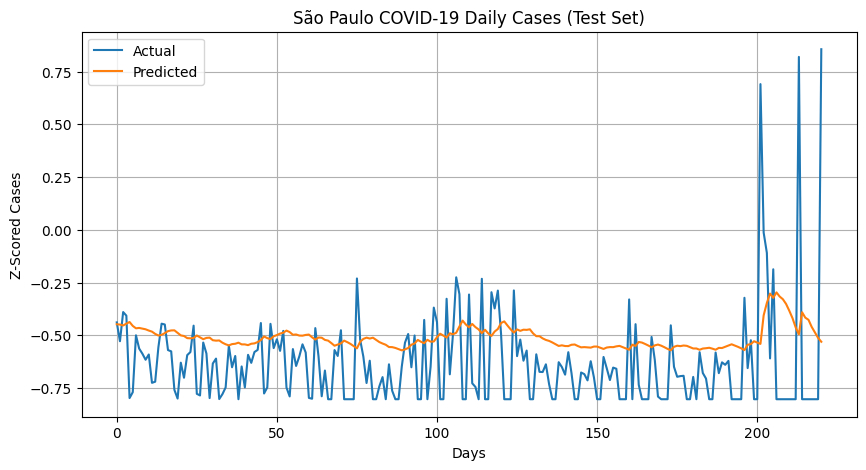

In [133]:
import matplotlib.pyplot as plt

G2 = nx.Graph()
for _, row in centrality_df.iterrows():
    city_id = int(row['Codmundv'])
    G2.add_node(city_id, name=row['nomemun'])

# Get the ordering of city IDs in the PyG graph
city_id_list = list(G2.nodes())


# IBGE code of São Paulo
sp_code = 3550308
sp_index = city_id_list.index(sp_code)  # If your node order is based on a list

# Extract predictions and ground truth for SP
sp_preds = [pred[sp_index].item() for pred in predictions]
sp_actuals = [true[sp_index][0].item() for true in actuals]

plt.figure(figsize=(10, 5))
plt.plot(sp_actuals, label='Actual')
plt.plot(sp_preds, label='Predicted')
plt.title("São Paulo COVID-19 Daily Cases (Test Set)")
plt.xlabel("Days")
plt.ylabel("Z-Scored Cases")
plt.legend()
plt.grid(True)
plt.show()


In [163]:
# Filter São Paulo full series
sp_full = filtered_covid_df[filtered_covid_df['ibgeID'] == sp_code].sort_values('date')

# Extract full z-scored series
full_z_series = sp_full['z_newCases'].tolist()
full_dates = sp_full['date'].tolist()


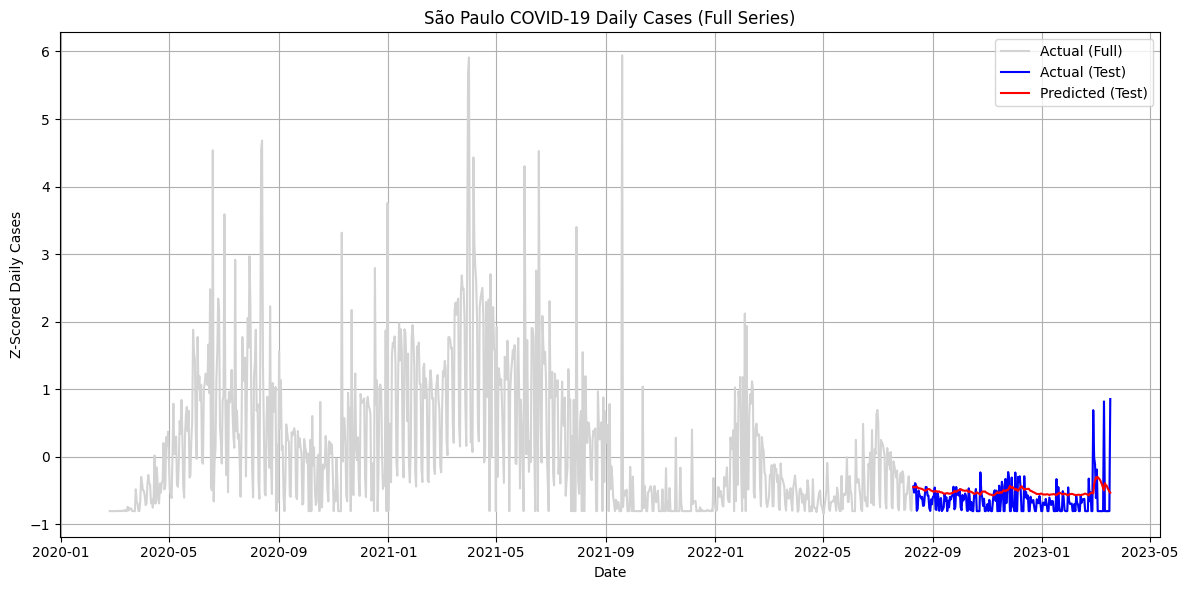

In [169]:
# Find index where test set starts (80% of the full time series segments)
start_index = len(full_z_series) - len(sp_actuals)

plt.figure(figsize=(12, 6))
plt.plot(full_dates, full_z_series, label='Actual (Full)', color='lightgray')
plt.plot(full_dates[start_index:], sp_actuals, label='Actual (Test)', color='blue')
plt.plot(full_dates[start_index:], sp_preds, label='Predicted (Test)', color='red')
plt.title("São Paulo COVID-19 Daily Cases (Full Series)")
plt.xlabel("Date")
plt.ylabel("Z-Scored Daily Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [170]:
import pandas as pd

# Convert to tensor: [num_days, num_nodes, 1]
z_cases = torch.tensor(pivot_df.values, dtype=torch.float32).unsqueeze(-1)

print("z_cases shape:", z_cases.shape)  # Should be [num_days, 5386, 1]


✅ z_cases shape: torch.Size([1118, 5386, 1])


In [171]:
# Segment size = 15 → predict the 16th
segment_len = 15

X_full = []
Y_full = []

for i in range(len(z_cases) - segment_len):
    X_full.append(z_cases[i:i+segment_len])     # [15, 5386, 1]
    Y_full.append(z_cases[i+segment_len])       # [5386, 1]

X_full = torch.stack(X_full)
Y_full = torch.stack(Y_full)

print("X_full:", X_full.shape)  # [num_segments, 15, 5386, 1]
print("Y_full:", Y_full.shape)  # [num_segments, 5386, 1]


X_full: torch.Size([1103, 15, 5386, 1])
Y_full: torch.Size([1103, 5386, 1])


In [172]:
from torch.utils.data import DataLoader, TensorDataset

full_dataset = TensorDataset(X_full, Y_full)
full_loader = DataLoader(full_dataset, batch_size=16, shuffle=False)
